In [2]:
# you might need these, I'll update the docker image soon!
! pip install GPSphoto geopandas exifread piexif cameratransform

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 3.8 MB/s eta 0:00:0000:0100:01
  Created wheel for GPSphoto: filename=gpsphoto-2.2.3-py3-none-any.whl size=11880 sha256=4f6f792212586589e95f67387031f897e101b308ae13968b0c52860b977493ea
  Stored in directory: /root/.cache/pip/wheels/2a/3a/ea/8aff4448f997d98966ac532c48ff572c53eea439a9d2de6676
Successfully built GPSphoto


In [1]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils_awedits2 import *
# from georeg import *


/usr/local/envs/micasense/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# project_path = os.path.join('../../../', '10_01_20', '0002SET', '000_test')
project_path = os.path.join('../../DroneWQ/data/test/test_dir')
project_path

'../../DroneWQ/data/test/test_dir'

### Reading metadata

In [7]:
raw_img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs')

write_exif_csv(img_set=raw_img_set, outputPath=project_path)

#AW- right now I have line 75 commented out because it gives that weird TIF reading error when I run process_micasense_subset.
#But... we might need other metadata in this csv for the georeferencing code??

Loading ImageSet from: ../../DroneWQ/data/test/test_dir/raw_water_imgs


'../../DroneWQ/data/test/test_dir/metadata.csv'

In [7]:
align_capture = imageset.ImageSet.from_directory(project_path+'/align_img').captures[0]
get_warp_matrix(align_capture) 

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4
Finished aligning band 1


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
        [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
        [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32),
 array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
        [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
        [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32),
 array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
        [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
        [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32),
 array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
        [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
        [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32),
 array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
        [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
        [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]

In [8]:
raw_img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs')
align_capture = imageset.ImageSet.from_directory(project_path+'/align_img').captures[0]

save_images(img_set = raw_img_set, outputPath=project_path+'/test_tifs', 
            thumbnailPath=project_path+'/test_thumbs', warp_img_capture=align_capture, 
            generateThumbnails=True, overwrite=True)


Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4
Finished aligning band 2


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:16.349962
Alignment+Saving rate: 0.24 images per second


True

In [5]:
process_micasense_subset(project_dir=project_path, warp_img_dir=project_path+'/align_img', overwrite=True, sky=False)

Loading ImageSet from: ../../DroneWQ/data/test/test_dir/raw_water_imgs
Loading ImageSet from: ../../DroneWQ/data/test/test_dir/align_img
used warp dir ../../DroneWQ/data/test/test_dir/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 4
Finished aligning band 2
Finished aligning band 1


/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  n

Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9632621e-01, -2.2406771e-03, -5.7682233e+00],
       [ 2.8431690e-03,  9.9737352e-01, -7.2834544e+00],
       [-1.3363119e-06,  2.3631749e-06,  1.0000000e+00]], dtype=float32), array([[ 9.9846864e-01,  5.9327376e-03, -3.1233097e+01],
       [-5.9657856e-03,  9.9850011e-01, -3.5932708e+00],
       [-1.7238908e-06,  1.8132982e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0051403e+00, -1.5849404e-03,  2.9105730e+00],
       [-8.0328999e-04,  9.9968708e-01,  7.8639565e+00],
       [ 2.6587659e-06, -4.9850751e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0048490e+00,  1.1748946e-03, -3.5358101e+01],
       [-1.0554740e-03,  1.0030918e+00, -4.1840172e+00],
       [ 2.2627594e-06, -9.8414216e-07,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:55.49447

    1 directories scanned
    8 image files updated


'../../DroneWQ/data/test/test_dir/lt_imgs'

(4, 5, 926, 1225)


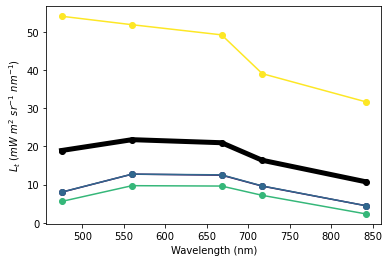

In [25]:
#plotting data from this function to make sure it looks good

lt_imgs, lt_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')
print(lt_imgs.shape)

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

for i in range(len(lt_imgs)):
    plt.plot(wv, lt_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="") 
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
plt.plot(wv, lt_imgs[:,0:5,:,:].mean(axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')


In [19]:
process_micasense_subset(project_dir=project_path, warp_img_dir=project_path+'/align_img', overwrite=True, sky=True)

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_sky_imgs
Loading ImageSet from: ../../../10_01_20/0002SET/000_test/align_img
used warp dir ../../../10_01_20/0002SET/000_test/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4
Finished aligning band 1


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9378926e-01, -2.7656062e-03, -5.9759774e+00],
       [ 2.6329539e-03,  9.9587196e-01, -7.3515229e+00],
       [-2.3312907e-06,  6.2926870e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9536967e-01,  5.5196560e-03, -3.1655077e+01],
       [-5.9288340e-03,  9.9737483e-01, -4.0017252e+00],
       [-2.7263882e-06, -4.5411207e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0052634e+00, -1.2817904e-03,  2.0012319e+00],
       [-2.7793428e-04,  1.0002136e+00,  7.4454026e+00],
       [ 3.0414039e-06, -5.4252382e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0033585e+00,  2.3333843e-04, -3.5850224e+01],
       [-5.0506106e-04,  1.0020356e+00, -4.8430800e+00],
       [ 2.3757659e-06, -2.8124521e-06,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:03.45833

    1 directories scanned
    2 image files updated


'../../../10_01_20/0002SET/000_test/sky_lt_imgs'

(2, 5, 926, 1225)


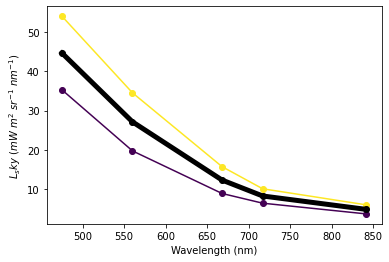

In [24]:
#plotting data from this function to make sure it looks good

lsky_imgs, lsky_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/sky_lt_imgs')
print(lsky_imgs.shape)

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lsky_imgs)))

for i in range(len(lsky_imgs)):
    plt.plot(wv, lsky_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$L_sky\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
plt.plot(wv, lsky_imgs[:,0:5,:,:].mean(axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')


array([1, 2, 3, 4, 5, 6, 7])

In [4]:
df = load_img_fn_and_meta(img_dir=project_path+'/lt_imgs')
df.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time
filename,,,,,,,,,,,,,,,
capture_1.tif,../../DroneWQ/data/test/test_dir/lt_imgs/captu...,2020:10:01,16:02:27,38.696407,N,-75.980256,W,87.371,5.43432,1280,960,-11.208938,-7.916905,-16.696712,2022-08-10 16:02:27
capture_2.tif,../../DroneWQ/data/test/test_dir/lt_imgs/captu...,2020:10:01,16:02:29,38.696414,N,-75.980192,W,87.063,5.43432,1280,960,-20.642214,-8.073487,-17.074646,2022-08-10 16:02:29
capture_3.tif,../../DroneWQ/data/test/test_dir/lt_imgs/captu...,2020:10:01,16:02:31,38.696411,N,-75.980187,W,86.925,5.43432,1280,960,-80.304408,-10.974186,-21.634724,2022-08-10 16:02:31
capture_4.tif,../../DroneWQ/data/test/test_dir/lt_imgs/captu...,2020:10:01,16:02:33,38.696399,N,-75.980194,W,86.926,5.43432,1280,960,-79.640905,-11.099981,25.742701,2022-08-10 16:02:33
capture_5.tif,../../DroneWQ/data/test/test_dir/lt_imgs/captu...,2020:10:01,16:02:35,38.696491,N,-75.980171,W,86.475,5.43432,1280,960,-80.106253,-9.188963,10.370811,2022-08-10 16:02:35


In [6]:
imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')

In [12]:
# PG edit: we could add any of this other metadata to the data we return in this function
#AW comment: would like to tlak about what metadata is appropriate to include in metadata.csv tables

with exiftool.ExifTool() as et:
    #md = et.get_metadata("../../DroneWQ/data/test/test_dir/sky_lt_imgs/capture_1.tif")
    md = et.get_metadata(project_path+"/lt_imgs/capture_1.tif")
md

{'SourceFile': '../../../10_01_20/0002SET/000_test/lt_imgs/capture_1.tif',
 'ExifTool:ExifToolVersion': 12.4,
 'File:FileName': 'capture_1.tif',
 'File:Directory': '../../../10_01_20/0002SET/000_test/lt_imgs',
 'File:FileSize': 19412086,
 'File:FileModifyDate': '2022:07:11 13:02:55+00:00',
 'File:FileAccessDate': '2022:07:11 13:02:55+00:00',
 'File:FileInodeChangeDate': '2022:07:11 13:02:55+00:00',
 'File:FilePermissions': 100644,
 'File:FileType': 'TIFF',
 'File:FileTypeExtension': 'TIF',
 'File:MIMEType': 'image/tiff',
 'File:ExifByteOrder': 'II',
 'EXIF:ImageWidth': 1225,
 'EXIF:ImageHeight': 926,
 'EXIF:BitsPerSample': '32 32 32 32 32',
 'EXIF:Compression': 8,
 'EXIF:PhotometricInterpretation': 1,
 'EXIF:StripOffsets': '(Binary data 39034 bytes, use -b option to extract)',
 'EXIF:SamplesPerPixel': 5,
 'EXIF:RowsPerStrip': 1,
 'EXIF:StripByteCounts': '(Binary data 23149 bytes, use -b option to extract)',
 'EXIF:PlanarConfiguration': 2,
 'EXIF:Predictor': 1,
 'EXIF:ExtraSamples': '0 

In [13]:
load_images(img_list = glob.glob(project_path+'/lt_imgs/*.tif'))


[array([[[0.00804333, 0.00793729, 0.00773955, ..., 0.00719604,
          0.00747167, 0.00748908],
         [0.00735689, 0.00753132, 0.00765531, ..., 0.00701523,
          0.00733989, 0.00748273],
         [0.0070529 , 0.00736668, 0.00762665, ..., 0.007519  ,
          0.00789201, 0.00806685],
         ...,
         [0.00548745, 0.00565179, 0.00592159, ..., 0.0056419 ,
          0.00576597, 0.00590172],
         [0.00541384, 0.00589847, 0.0058062 , ..., 0.00616943,
          0.00618882, 0.00583156],
         [0.00548837, 0.00547596, 0.00544705, ..., 0.0061988 ,
          0.006068  , 0.00617601]],
 
        [[0.01305651, 0.01384114, 0.0139703 , ..., 0.01173149,
          0.01156621, 0.01155434],
         [0.01283234, 0.01349893, 0.01370834, ..., 0.01144142,
          0.01162629, 0.01156501],
         [0.0129366 , 0.0130481 , 0.01351238, ..., 0.01119716,
          0.01085365, 0.01097419],
         ...,
         [0.01118851, 0.011319  , 0.01076224, ..., 0.01033175,
          0.01034655, 0.

In [14]:
retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')

(array([[[[0.00804333, 0.00793729, 0.00773955, ..., 0.00719604,
           0.00747167, 0.00748908],
          [0.00735689, 0.00753132, 0.00765531, ..., 0.00701523,
           0.00733989, 0.00748273],
          [0.0070529 , 0.00736668, 0.00762665, ..., 0.007519  ,
           0.00789201, 0.00806685],
          ...,
          [0.00548745, 0.00565179, 0.00592159, ..., 0.0056419 ,
           0.00576597, 0.00590172],
          [0.00541384, 0.00589847, 0.0058062 , ..., 0.00616943,
           0.00618882, 0.00583156],
          [0.00548837, 0.00547596, 0.00544705, ..., 0.0061988 ,
           0.006068  , 0.00617601]],
 
         [[0.01305651, 0.01384114, 0.0139703 , ..., 0.01173149,
           0.01156621, 0.01155434],
          [0.01283234, 0.01349893, 0.01370834, ..., 0.01144142,
           0.01162629, 0.01156501],
          [0.0129366 , 0.0130481 , 0.01351238, ..., 0.01119716,
           0.01085365, 0.01097419],
          ...,
          [0.01118851, 0.011319  , 0.01076224, ..., 0.01033175,
   

In [6]:
std_glint_removal_method(lt_dir = project_path+'/lt_imgs', glint_corrected_lt_dir = project_path+'/lt_glint_corrected_imgs', glint_std_factor=1)

#AW- not sure about grabbing the first 10 images.. these could be 10 without any glint so the mean and std would be a lot lower. I changed to 50?
#AW- we're currently removing different pixels from each band in an image since we're finding a different glint threshold for each of the 5 bands. 
#I changed this so we're only doing the glint filtering on the NIR band and applying that filtering to all bands. 


#manually made 'lt_glint_corrected_imgs' folder for this function to work 

The mean and std of Lt from first 50 images is:  0.010728069 0.031780522
Pixels will be masked where Lt(NIR) >  0.04250859096646309


True

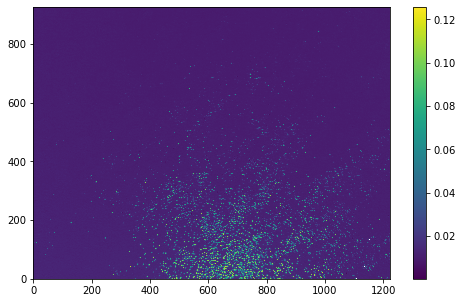

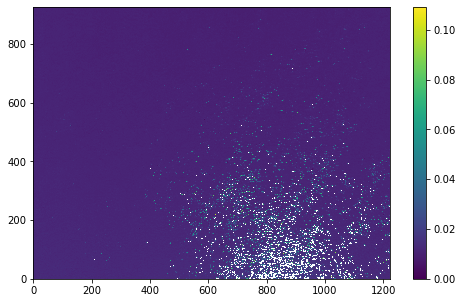

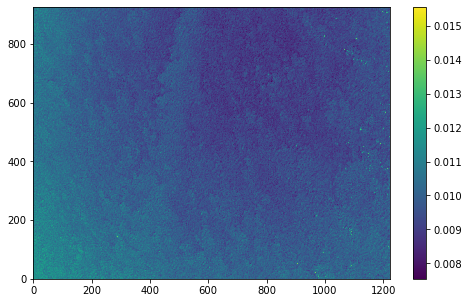

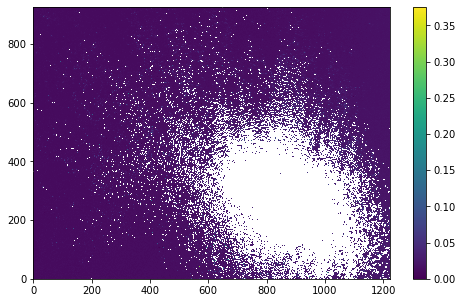

In [7]:
#plot individual tifs to see if glint is masked 

glint_corrected_lt_dir = project_path+'/lt_glint_corrected_imgs'

for im in glob.glob(glint_corrected_lt_dir + "/*.tif"):
    with rasterio.open(im, 'r') as Lt_src:
        profile = Lt_src.profile
        fig = plt.figure(figsize=(8,5))
        plt.pcolormesh(Lt_src.read(2))
        cbar = plt.colorbar()

In [8]:
mobley_rho_method(sky_lt_dir = project_path+'/sky_lt_imgs', lt_dir = project_path+'/lt_imgs', lw_dir = project_path+'/lw_imgs', rho=0.028)

#manually made 'lw_imgs' folder for this function to work

True

In [10]:
blackpixel_method(sky_lt_dir = project_path+'/sky_lt_imgs', lt_dir = project_path+'/lt_imgs', lw_dir = project_path+'/lw_imgs')

#manually made 'lw_imgs' folder for this function to work

True

In [12]:
hedley_method(lt_dir = project_path+'/lt_imgs', lw_dir = project_path+'/lw_imgs')

#manually made 'lw_imgs' folder for this function to work

In [5]:
panel_ed(panel_dir = project_path+'/panel', lw_dir = project_path+'/lw_imgs', rrs_dir = project_path+'/rrs_imgs', output_csv_path=project_path)

#manually made 'rrs_imgs' directory for the function to work 

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/panel


True

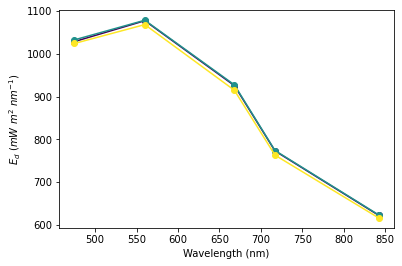

In [11]:
#Plotting data to make sure it looks good

ed = pd.read_csv(project_path+'/panel_ed.csv') 

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    plt.plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 


In [7]:
dls_ed(raw_water_dir=project_path+'/raw_water_imgs', lw_dir = project_path+'/lw_imgs', rrs_dir = project_path+'/rrs_imgs', output_csv_path=project_path)

#manually made 'rrs_imgs' directory for the function to work 

Loading ImageSet from: ../../../10_01_20/0002SET/000_test/raw_water_imgs


True

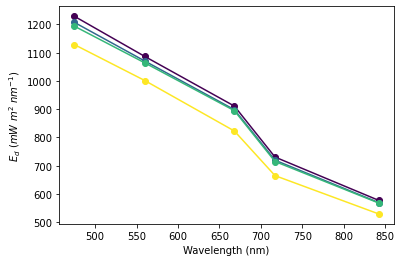

In [12]:
#Plotting data to make sure it looks good

ed = pd.read_csv(project_path+'/dls_ed.csv') 

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    plt.plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)')



In [8]:
project_path

'../../DroneWQ/data/test/test_dir'

In [4]:
process_raw_to_rrs(main_dir=project_path, ed_method='panel_ed', glint_correct=True, glint_std_factor=1, surface_reflection_correction='mobley_rho_method', output_csv_path=project_path)

#Ran the function with all possible combinations of arguments and all are working

Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: ../../DroneWQ/data/test/test_dir/raw_water_imgs
Loading ImageSet from: ../../DroneWQ/data/test/test_dir/align_img
used warp dir ../../DroneWQ/data/test/test_dir/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4


/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  n

Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9632621e-01, -2.2406771e-03, -5.7682233e+00],
       [ 2.8431690e-03,  9.9737352e-01, -7.2834544e+00],
       [-1.3363119e-06,  2.3631749e-06,  1.0000000e+00]], dtype=float32), array([[ 9.9846864e-01,  5.9327376e-03, -3.1233097e+01],
       [-5.9657856e-03,  9.9850011e-01, -3.5932708e+00],
       [-1.7238908e-06,  1.8132982e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0051403e+00, -1.5849404e-03,  2.9105730e+00],
       [-8.0328999e-04,  9.9968708e-01,  7.8639565e+00],
       [ 2.6587659e-06, -4.9850751e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0048490e+00,  1.1748946e-03, -3.5358101e+01],
       [-1.0554740e-03,  1.0030918e+00, -4.1840172e+00],
       [ 2.2627594e-06, -9.8414216e-07,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:51.47275

/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/drone_ioccg_work/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  n

Finished Aligning, warp matrices=[array([[ 1.0000000e+00, -8.6219393e-19,  0.0000000e+00],
       [-6.5323213e-19,  1.0000000e+00,  0.0000000e+00],
       [-1.3339226e-22, -4.2048379e-22,  1.0000000e+00]], dtype=float32), array([[ 9.9092090e-01,  7.3246547e-04, -8.6758029e-01],
       [ 6.0073420e-04,  9.8712063e-01, -4.7487357e-01],
       [ 1.5979347e-06,  1.3665929e-06,  1.0000000e+00]], dtype=float32), array([[ 9.9366832e-01,  8.2020154e-03, -3.2748260e+01],
       [ 4.2649364e-04,  9.9169523e-01,  3.5683990e-02],
       [ 4.4667590e-07, -7.3243618e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0103391e+00,  2.8778198e-03, -7.4464756e-01],
       [ 6.7657917e-03,  9.8913866e-01,  1.2885010e+01],
       [ 7.3613364e-06,  4.2012930e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0008420e+00,  1.9418603e-02, -4.1944111e+01],
       [ 7.0762925e-04,  9.9563247e-01, -3.0119851e-02],
       [ 7.9217926e-07, -3.6346937e-06,  1.0000000e+00]], dtype=float32)]
Saving time: 0:00:10.15160

True

(8, 5, 927, 1225)
(2, 5, 946, 1230)


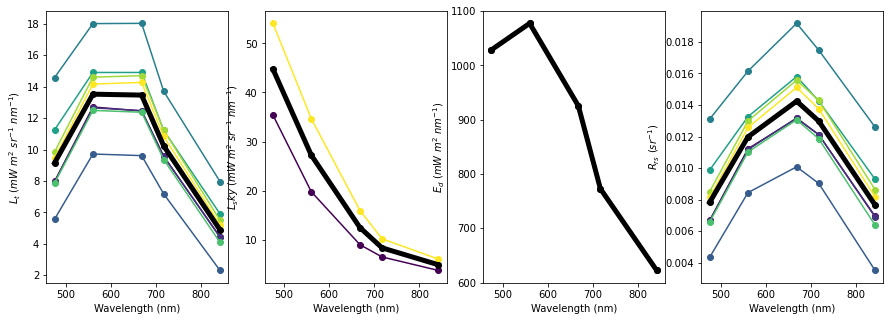

In [6]:
#Plotting data to make sure it looks good

fig, ax = plt.subplots(1,4, figsize=(15,5))

#lt
lt_imgs, lt_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_glint_corrected_imgs')
print(lt_imgs.shape)

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

for i in range(len(lt_imgs)):
    ax[0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    ax[0].set_xlabel('Wavelength (nm)')
    ax[0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
ax[0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')

#lsky
lsky_imgs, lsky_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/sky_lt_imgs')
print(lsky_imgs.shape)
wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lsky_imgs)))

for i in range(len(lsky_imgs)):
    ax[1].plot(wv, lsky_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    ax[1].set_xlabel('Wavelength (nm)')
    ax[1].set_ylabel('$L_sky\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)') 
    
ax[1].plot(wv, lsky_imgs[:,0:5,:,:].mean(axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')

#ed
ed = pd.read_csv(project_path+'/panel_ed.csv')
#ed = pd.read_csv(project_path+'/dls_ed.csv')


colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    ax[2].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) #multiply by 1000 to convert to mW
    ax[2].set_xlabel('Wavelength (nm)')
    ax[2].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 

ax[2].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Average')

#rrs
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_imgs')

colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs)))

for i in range(len(rrs_imgs)):
    ax[3].plot(wv, np.nanmean(rrs_imgs[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    ax[3].set_xlabel('Wavelength (nm)')
    ax[3].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
    
ax[3].plot(wv, np.nanmean(rrs_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

plt.show()


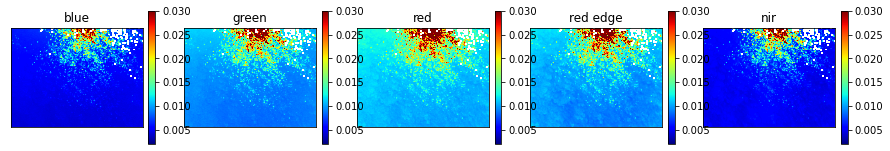

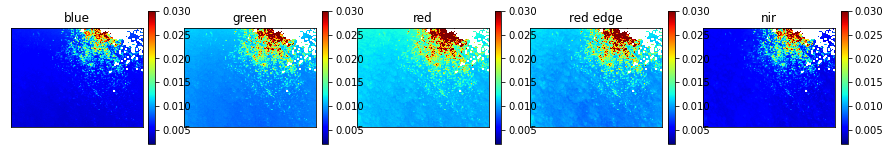

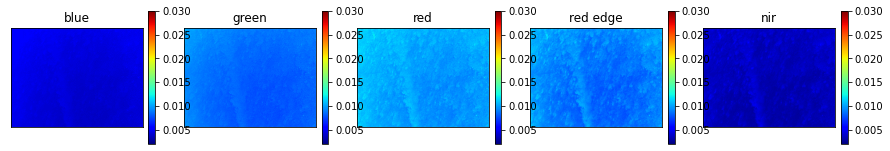

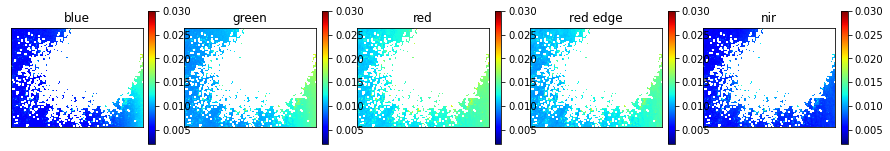

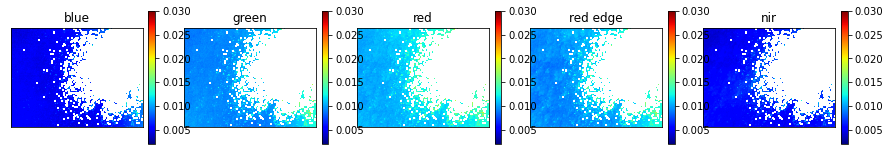

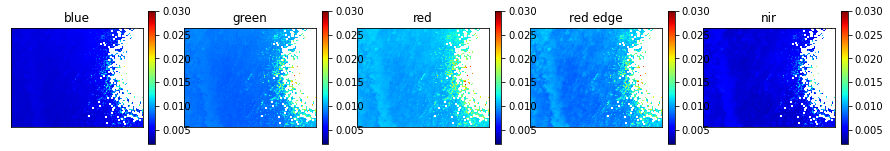

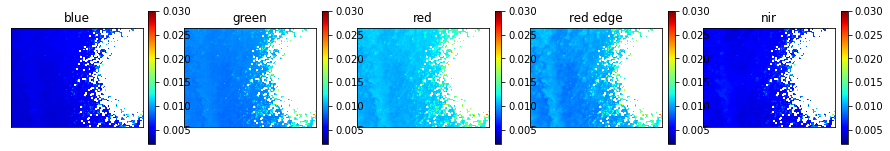

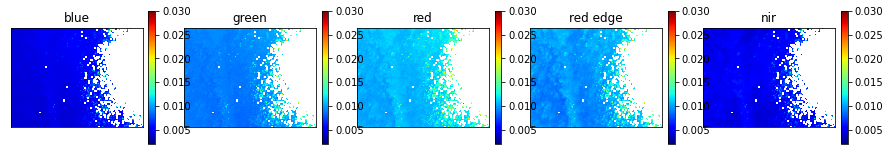

In [7]:
#plot individual tifs
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(8):
    fig, ax = plt.subplots(1,5, figsize=(15,4))

    for i in range(5):
        im = ax[i].imshow(rrs_imgs[j,i],cmap='jet', vmin=0.002, vmax=0.03)
        fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    plt.show()
    
#These seem to be in accurate Rrs value range

In [16]:
rrs_img_metadata.columns

Index(['SourceFile', '    GPSDateStamp', '    GPSTimeStamp', '    GPSLatitude',
       '    GPSLatitudeRef', '    GPSLongitude', '    GPSLongitudeRef',
       '    GPSAltitude', '    FocalLength', '    ImageWidth', 'ImageHeight',
       '    GPSImgDirection', 'GPSPitch', 'GPSRoll', 'UTC-Time', 'id'],
      dtype='object')

Text(0, 0.5, 'Latitude')

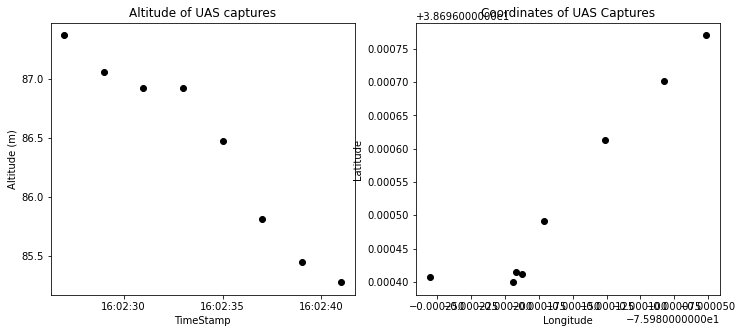

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#plot altitude
ax[0].scatter(rrs_img_metadata['UTC-Time'].values, rrs_img_metadata['    GPSAltitude'].values, color='black')
# ax[0].set_xticks(rotation=60)
ax[0].set_title("Altitude of UAS captures")
ax[0].set_xlabel("TimeStamp")
ax[0].set_ylabel("Altitude (m)")

#plot lat, lon
ax[1].scatter(rrs_img_metadata['    GPSLongitude'].values, rrs_img_metadata['    GPSLatitude'].values, color='black')
ax[1].set_title("Coordinates of UAS Captures")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

### Testing bio-optical algorithms

#AWcomment- these still need to be finalized... There are some other Chl algs for coastal waters we can try (Ruddick, Gons, Gitelson) <br>
#I think it would make sense to have a function that converts these arrays into points so you can map chl/TSM by points on a map

In [5]:
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_imgs')

rrs_imgs.shape

(4, 5, 926, 1225)

In [33]:
chl_oc_index = oc_index(rrs_imgs[1,0,:,:], rrs_imgs[1,1,:,:], rrs_imgs[1,2,:,:])

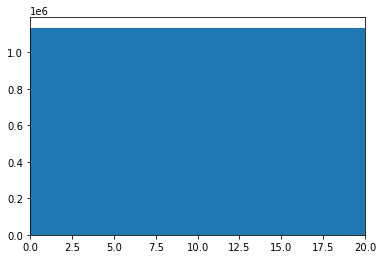

In [34]:
plt.hist(chl_oc_index.flatten(),bins=50)
plt.xlim(0,20)
plt.show()

In [36]:
np.nanmax(chl_oc_index)

702058900000.0

In [37]:
chl_oc_index[chl_oc_index > 50] = 50

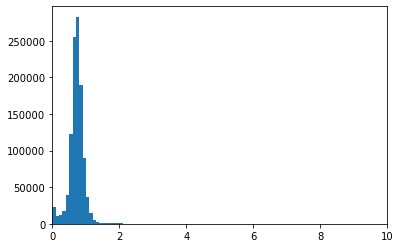

In [38]:
plt.hist(chl_oc_index.flatten(),bins=500)
plt.xlim(0,10)
plt.show()

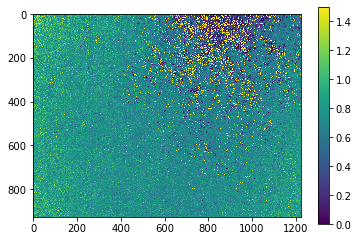

In [39]:
plt.imshow(chl_oc_index, vmin=0, vmax=1.5, interpolation='none')
cbar = plt.colorbar()

In [44]:
#attempting to calcualting Chl for every image and convert to points 
for i in range(len(rrs_imgs)):
    chl_oc_index = oc_index(rrs_imgs[i,0,:,:], rrs_imgs[i,1,:,:], rrs_imgs[i,2,:,:])
    print(chl_oc_index)
    print(np.nanmax(chl_oc_index))
    chl_point = np.nanmean(chl_oc_index, axis=(0,1))
    print(chl_point)

[[0.9469807  1.188831   1.5173168  ... 0.8624968  0.7427326  0.6873361 ]
 [1.1535815  1.2104778  1.2564459  ... 0.81529295 0.7350421  0.68351185]
 [1.1548909  1.1101853  1.1350533  ... 0.60972583 0.5017372  0.45752418]
 ...
 [0.99820966 0.946233   0.83155763 ... 0.6839694  0.78331983 0.8516988 ]
 [0.93977094 0.7857351  0.8233944  ... 0.5877231  0.8990047  1.0317868 ]
 [1.0048342  0.82376397 0.90766484 ... 0.68908894 1.032148   1.0718927 ]]
2538127000000.0
2741571.8
[[1.0466237  1.0396695  0.9864618  ... 0.657174   0.54729456 0.462419  ]
 [0.91172934 1.0292193  1.0282594  ... 0.47631198 0.5781828  0.5758994 ]
 [0.9026381  1.0436001  1.1894023  ... 0.44097698 0.56412554 0.62832236]
 ...
 [1.1356784  1.1211948  1.0699335  ... 0.79923654 0.8298038  0.69158006]
 [0.9144633  1.0095849  1.0495604  ... 0.87111855 0.8630681  0.9856027 ]
 [1.0015497  1.0393624  1.0358527  ... 0.7417753  0.80878246 0.7985634 ]]
248223610000.0
330072.62
[[0.7458059  0.80245334 0.8509193  ... 0.5347842  0.7151337  

In [ ]:
L2_chlor_a = L2chlor_a()

#AWcomment- will this one work with MicSense imagery?

In [ ]:
convert_to_ocean_color_gdf()

#Aw- what is spectra list?

In [31]:
vec_chla_img = vec_chla_img(rrs_imgs[0,0,:,:], rrs_imgs[0,1,:,:])
vec_chla_img

#AWcomment- not sure why I'm getting this error?

TypeError: 'numpy.ndarray' object is not callable

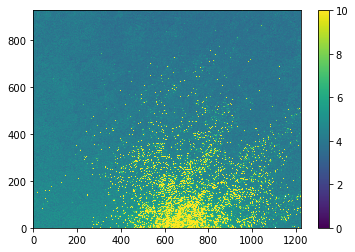

In [7]:
tsm = nechad_tsm(rrs_imgs[0,2,:,:])

plt.pcolormesh(tsm, vmin=0, vmax=10)
cbar = plt.colorbar()

#AWcomment- the coefficients used in this alg aren't correct. need to do more research on this

### Georeferencing 

#AWcomment- the cameratransform python module needs to be uploaded into the Docker I think?

In [8]:
metadata = pd.read_csv(project_path + '/metadata.csv')
metadata

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,GPSImgDirection,GPSPitch,GPSRoll
0,../../../10_01_20/0002SET/000_test/capture_1.tif,2020:10:01,16:02:27,38.696407,N,-75.980256,W,87.371,5.43432,-11.208938,-7.916905,-16.696712
1,../../../10_01_20/0002SET/000_test/capture_2.tif,2020:10:01,16:02:29,38.696414,N,-75.980192,W,87.063,5.43432,-20.642214,-8.073487,-17.074646
2,../../../10_01_20/0002SET/000_test/capture_3.tif,2020:10:01,16:02:31,38.696411,N,-75.980187,W,86.925,5.43432,-80.304408,-10.974186,-21.634724
3,../../../10_01_20/0002SET/000_test/capture_4.tif,2020:10:01,16:02:33,38.696399,N,-75.980194,W,86.926,5.43432,-79.640905,-11.099981,25.742701


In [9]:
import cameratransform as ct


ModuleNotFoundError: No module named 'cameratransform'